# Decoding errors and their effect on the QEC
In our thesis, we investigated the performance of the smallest possible quantum error correcting code (QECC) capable of correcting any single qubit error. This code, the $[\![5,1,3]\!]$ stabilizer code, could be a potentially interesting test case for error correction on near-term hardware. We identified the main bottleneck as a form of decoding error cause by noise occuring in-between the stabilizer measurements.
 
## Recap of the code
The code uses five qubits to redundantly store the information of a single logical qubit. Errors are detected using the four stabilizer generators
$$
g_{1} = X Z Z X I \\
g_{2} = I X Z Z X \\
g_{3} = X I X Z Z \\
g_{4} = Z X I X Z.
$$
These are Hermitian observables with eigenvalues $+1$ and $-1$, and error-free states are defined as the simultaneous eigenvectors with an eigenvalue of $+1$ for each of them (they are said to be stabilized). Measuring these four observables, which has to be done one at a time using the circuit below, gives a four bit string (we refer to $+1$ outcomes as $'0'$ and $-1$ as $'1'$ and write the measurements from right to left) which uniquely identifies every single qubit Pauli error on any of the qubits. Here, $'0000'$ signifies an error free state and e.g. $'0110'$ signifies the occurance of $X_4$, i.e. a bit-flip error on the fourth qubit. 

*(This embedded image cannot be rendered by vscode)*

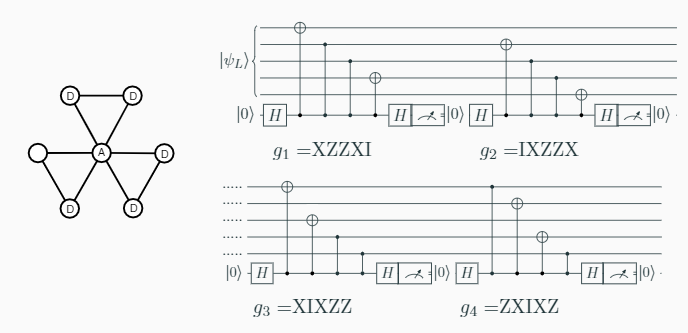

## Decoding errors
How do decoding errors impact the performance of the error correction? Let's run some simulations and see.

In [3]:
# Set up simulations and load the data
from simulator_program.data_analysis_tools import default_simulate_persist_to_file
from simulator_program.custom_noise_models import standard_times, standard_times_delay, GateTimes
import decoding_errors
file_name = 'decoding_data/cache.dat'

## Print the kwargs for the runs that are saved in the file
# decoding_errors.print_saved_runs(file_name)
# kwargs = {k:v for k,v in {('idle_delay', 'before'), ('include_barriers', True), ('include_fifth_stabilizer', False), ('n_cycles', 3), ('generator_snapshot', True), ('encoding', False), ('reset', True), ('idle_snapshots', 2), ('conditional', False), ('recovery', True), ('final_measure', False)}}

kwargs = {
    'n_cycles': 4,
    'reset': True,
    'recovery': True,
    'encoding': False,
    'conditional': False,
    'include_barriers': True,
    'generator_snapshot': True,
    'idle_snapshots': 0,
    'final_measure': False,
    'idle_delay': 'before',
    'include_fifth_stabilizer': False}

kwargs2 = {
    'n_cycles': 4,
    'reset': True,
    'recovery': True,
    'encoding': False,
    'conditional': False,
    'include_barriers': True,
    'generator_snapshot': True,
    'idle_snapshots': 10,
    'final_measure': False,
    'idle_delay': 'before',
    'include_fifth_stabilizer': False}

T1 = [40e3]*5+[100000000000, 100000000000]
T2 = [60e3]*5+[100000000000, 100000000000]

gate_times = standard_times  # .get_gate_times({'feedback':0})
gate_times2 = GateTimes(0, 0, {'delay': 3310})

n_shots = 1024*2

print('Is a run with these settings saved?', decoding_errors.check_if_saved(
    kwargs, T1, T2, gate_times, file_name=file_name))
print('Is a run with these settings saved?', decoding_errors.check_if_saved(
    kwargs2, T1, T2, gate_times2, file_name=file_name))

save_to_file = False
overwrite = False

results, times = default_simulate_persist_to_file(
    kwargs, T1, T2, gate_times, file_name=file_name, overwrite=overwrite, save_to_file=save_to_file)
results2, times2 = default_simulate_persist_to_file(
    kwargs2, T1, T2, gate_times2, file_name=file_name, overwrite=overwrite, save_to_file=save_to_file)


Is a run with these settings saved? True
Is a run with these settings saved? True


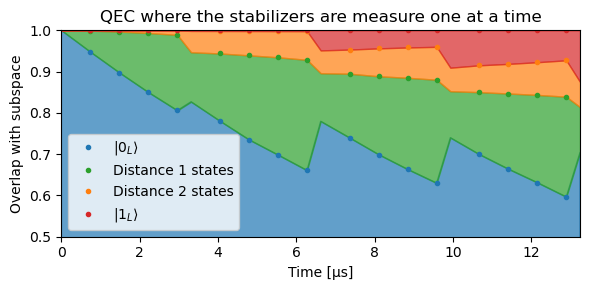

In [7]:
decoding_errors.plot_overlap(results, times, title='QEC where the stabilizers are measure one at a time',**kwargs)

This is how normal repeated QEC looks. The stabilizers have to be measured one at a time.

If, instead, we let the qubits idle for the same amount of time that one cycle of error correction normal time and make the stabilizer measurements instantaneous, then we can remove these decoding errors and we get the intended behaviour.

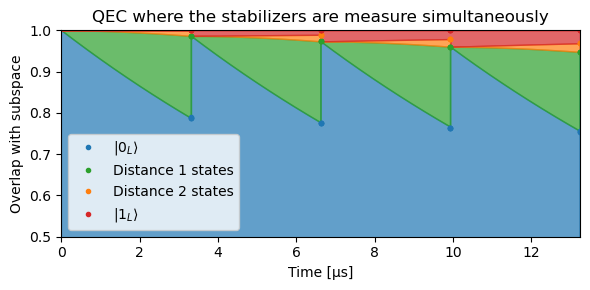

In [8]:
decoding_errors.plot_overlap(results2, times2,title='QEC where the stabilizers are measure simultaneously', **kwargs2)

This is caused by the fact that we need to measure one generator at a time. This is not the case for other stabilizer codes, e.g. the surface code where this can be done in parallell. The system starts in an error-free $'0000'$ state. If, e.g. the error $Y_4$, which is identified by the syndrome $'1111'$, occurs in between the second and the third stabilizer measurement, then the two first (rightmost) bits would be incorrectly identified as zeros, causing the syndrome to be read as $'1100'$. If one then tries to correct using this syndromes, which corresponds to an $X_5$ error, it will effectively cause two errors.

## In more detail
The $[\![5,1,3]\!]$ code is constructed in such a way that starting from a logical state $\alpha\ket{0_L}+\beta\ket{1_L}$, every single-qubit pauli operator $E$ will map the state to a *unique* orthagonal subspace. One can then measure which of these orthagonal subspaces the state resides in and map it back to the codespace without affecting the underlying state.

The codepace is 2-dimensional, and this property requires an additional 2-dimensional orthogonal subspace for every Pauli operator. There are three (X, Y and Z) Pauli operators for each qubit, which requires $2 \cdot (1+3\cdot5) = 32$ dimensions. This is exactly sattisfied by the $2^5=32$ dimensional Hilbert space. The $[\![5,1,3]\!]$ code is the smallest where this is possible. 